In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
import torch
import torch._dynamo
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, mean_squared_error
from helpers.movie_lens_data import MovieLensData, MovieLensDataset
from helpers.neural_collabarative_filtering import NeuralCollaborativeFiltering
from helpers.train_tools import EarlyStopper

C:\Users\Rafael Tejon\AppData\Local\Temp\ipykernel_26648\4134457685.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
path = "..\data\ml-100k"
movie_lens_data = MovieLensData(
    users_path = os.path.join(path, "u.user"),
    ratings_path = os.path.join(path, "u.data"), 
    movies_path = os.path.join(path, "u.item"), 
    genre_path = os.path.join(path, "u.genre") 
    )

evaluation_data = movie_lens_data.read_ratings_data()
movie_data = movie_lens_data.read_movies_data()
popularity_rankings = movie_lens_data.get_popularity_ranks()
ratings = movie_lens_data.get_ratings()

def get_dataset():
    return MovieLensDataset(ratings)

In [3]:
def get_model(dataset):
    field_dims = dataset.field_dims
    return NeuralCollaborativeFiltering(field_dims, embed_dim=64, mlp_dims=(32, 32), dropout=0.2,
                                       user_field_idx=dataset.user_field_idx,
                                       item_field_idx=dataset.item_field_idx) 

In [4]:
def train(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    tk0 = tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0)
    av_loss = []
    for i, (fields, target) in enumerate(tk0):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            loss = total_loss / log_interval
            av_loss.append(loss)
            tk0.set_postfix(loss=loss)
            total_loss = 0
    return np.mean(av_loss)

In [5]:
def test(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return 5.* mean_squared_error(targets, predicts)   

In [6]:
device_cpu = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 0.001
weight_decay = 1e-4
batch_size = 64
epochs = 20
model_name = "ncf"
device = torch.device(device_cpu)

In [7]:
dataset = get_dataset()
train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
test_length = len(dataset) - train_length - valid_length

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
        dataset, (train_length, valid_length, test_length))

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

In [8]:
model = get_model(dataset).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
early_stopper = EarlyStopper(num_trials=5, save_path=f'{model_name}.pt')

In [9]:
metric_values = []
loss_values = []

for epoch_i in range(epochs):

    loss = train(model, optimizer, train_data_loader, criterion, device)
    loss_values.append((epoch_i, loss))
    metric_valid = test(model, valid_data_loader, device)
    print('epoch:', epoch_i + 1, 'validation: mae:', metric_valid)
    
    metric_train = test(model, train_data_loader, device)
    print('train mae:', metric_train)
    
    metric_test = test(model, test_data_loader, device)
    print(f'test mae: {metric_test}')
    
    metric_values.append((epoch_i, metric_train, metric_valid, metric_test))
    
    if not early_stopper.is_continuable(model, metric_valid):
        print(f'validation: best mae: {early_stopper.best_accuracy}')
        break

100%|██████████| 157/157 [00:06<00:00, 23.57it/s]


epoch: 1 validation: mae: 0.18380500495271682


100%|██████████| 1250/1250 [00:07<00:00, 168.40it/s]


train mae: 0.17275463130643012


100%|██████████| 157/157 [00:06<00:00, 24.62it/s]


test mae: 0.1830583515517591
ES accuracy: 0.18380500495271682


100%|██████████| 157/157 [00:06<00:00, 25.09it/s]


epoch: 2 validation: mae: 0.18053115409208453


100%|██████████| 1250/1250 [00:07<00:00, 163.46it/s]


train mae: 0.16643128623322043


100%|██████████| 157/157 [00:06<00:00, 25.22it/s]


test mae: 0.17883499264151942
ES accuracy: 0.18053115409208453


100%|██████████| 157/157 [00:06<00:00, 25.51it/s]


epoch: 3 validation: mae: 0.17986929922099876


100%|██████████| 1250/1250 [00:07<00:00, 161.98it/s]


train mae: 0.16434735118338803


100%|██████████| 157/157 [00:07<00:00, 21.86it/s]


test mae: 0.17832097818211712
ES accuracy: 0.17986929922099876


100%|██████████| 157/157 [00:06<00:00, 24.35it/s]


epoch: 4 validation: mae: 0.1789467341326464


100%|██████████| 1250/1250 [00:07<00:00, 170.26it/s]


train mae: 0.16257854297122876


100%|██████████| 157/157 [00:06<00:00, 23.98it/s]


test mae: 0.17806055412935023
ES accuracy: 0.1789467341326464


100%|██████████| 157/157 [00:06<00:00, 22.73it/s]


epoch: 5 validation: mae: 0.17897855249363726


100%|██████████| 1250/1250 [00:07<00:00, 162.17it/s]


train mae: 0.1608605451561435


100%|██████████| 157/157 [00:06<00:00, 24.23it/s]


test mae: 0.1768505133236567
ES accuracy: 0.17897855249363726


100%|██████████| 157/157 [00:06<00:00, 23.70it/s]


epoch: 6 validation: mae: 0.17912169843325787


100%|██████████| 1250/1250 [00:07<00:00, 163.71it/s]


train mae: 0.16002525407565873


100%|██████████| 157/157 [00:06<00:00, 23.92it/s]


test mae: 0.17643526861091458
ES accuracy: 0.17912169843325787


100%|██████████| 157/157 [00:06<00:00, 24.33it/s]


epoch: 7 validation: mae: 0.17853992565809462


100%|██████████| 1250/1250 [00:07<00:00, 167.44it/s]


train mae: 0.15843801295062868


100%|██████████| 157/157 [00:06<00:00, 24.28it/s]


test mae: 0.17536059500868065
ES accuracy: 0.17853992565809462


100%|██████████| 157/157 [00:09<00:00, 16.96it/s]


epoch: 8 validation: mae: 0.1789266947618823


100%|██████████| 1250/1250 [00:08<00:00, 139.08it/s]


train mae: 0.15600266603615942


100%|██████████| 157/157 [00:08<00:00, 19.43it/s]


test mae: 0.17600664907447328
ES accuracy: 0.1789266947618823


100%|██████████| 157/157 [00:07<00:00, 20.92it/s]


epoch: 9 validation: mae: 0.17860744107130375


100%|██████████| 1250/1250 [00:11<00:00, 110.42it/s]


train mae: 0.15535193832644903


100%|██████████| 157/157 [00:07<00:00, 19.89it/s]


test mae: 0.1751398111568689
ES accuracy: 0.17860744107130375


100%|██████████| 157/157 [00:07<00:00, 20.42it/s]


epoch: 10 validation: mae: 0.17789673050366647


100%|██████████| 1250/1250 [00:09<00:00, 127.35it/s]


train mae: 0.1530355743984584


100%|██████████| 157/157 [00:07<00:00, 20.83it/s]


test mae: 0.17533548132746643
ES accuracy: 0.17789673050366647


100%|██████████| 157/157 [00:07<00:00, 20.66it/s]


epoch: 11 validation: mae: 0.17852375290884612


100%|██████████| 1250/1250 [00:08<00:00, 143.45it/s]


train mae: 0.15128201871780458


100%|██████████| 157/157 [00:07<00:00, 20.63it/s]


test mae: 0.17533744185282163
ES accuracy: 0.17852375290884612


100%|██████████| 157/157 [00:07<00:00, 20.00it/s]


epoch: 12 validation: mae: 0.17622297964329567


100%|██████████| 1250/1250 [00:09<00:00, 138.67it/s]


train mae: 0.14901742338591473


100%|██████████| 157/157 [00:07<00:00, 19.89it/s]


test mae: 0.17449032864000985
ES accuracy: 0.17622297964329567


100%|██████████| 157/157 [00:08<00:00, 18.48it/s]


epoch: 13 validation: mae: 0.17634054880316846


100%|██████████| 1250/1250 [00:08<00:00, 139.06it/s]


train mae: 0.1482906596591244


100%|██████████| 157/157 [00:08<00:00, 19.59it/s]


test mae: 0.17536814633807435
ES accuracy: 0.17634054880316846


100%|██████████| 157/157 [00:08<00:00, 18.96it/s]


epoch: 14 validation: mae: 0.177051786900263


100%|██████████| 1250/1250 [00:11<00:00, 113.49it/s]


train mae: 0.14772442971263486


100%|██████████| 157/157 [00:08<00:00, 18.26it/s]


test mae: 0.17570132424753565
ES accuracy: 0.177051786900263


100%|██████████| 157/157 [00:07<00:00, 21.28it/s]


epoch: 15 validation: mae: 0.1777394709801784


100%|██████████| 1250/1250 [00:08<00:00, 146.84it/s]


train mae: 0.1466924359356648


100%|██████████| 157/157 [00:07<00:00, 21.35it/s]


test mae: 0.17616679838083965
ES accuracy: 0.1777394709801784


100%|██████████| 157/157 [00:07<00:00, 21.43it/s]


epoch: 16 validation: mae: 0.1774114255031885


100%|██████████| 1250/1250 [00:08<00:00, 148.19it/s]


train mae: 0.14388922742371862


100%|██████████| 157/157 [00:07<00:00, 21.43it/s]


test mae: 0.17601452210253749
ES accuracy: 0.1774114255031885


100%|██████████| 157/157 [00:07<00:00, 20.08it/s]


epoch: 17 validation: mae: 0.1781817618535742


100%|██████████| 1250/1250 [00:08<00:00, 146.64it/s]


train mae: 0.14218407044713122


100%|██████████| 157/157 [00:07<00:00, 21.00it/s]

test mae: 0.1768753138985901
ES accuracy: 0.1781817618535742
validation: best mae: 0.17622297964329567


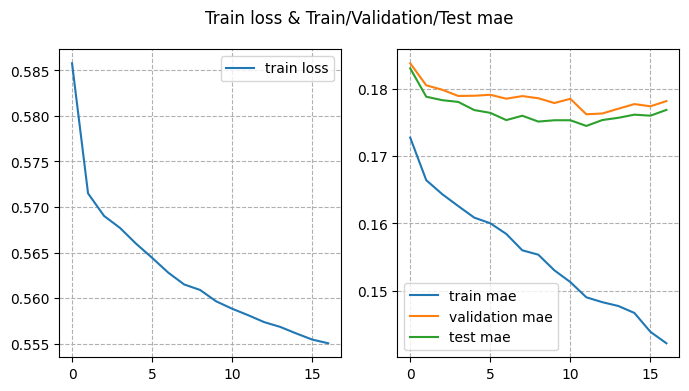

In [10]:
from matplotlib import pyplot as plt
metric_values = np.array(metric_values)
loss_values = [x[1] for x in loss_values]
f, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(loss_values, label="train loss")
ax[0].legend()
ax[0].grid(linestyle="--",which="major")

ax[1].plot(metric_values[:, 1], label="train mae")
ax[1].plot(metric_values[:, 2], label="validation mae")
ax[1].plot(metric_values[:, 3], label="test mae")
ax[1].legend()
ax[1].grid(linestyle="--",which="major")
plt.suptitle("Train loss & Train/Validation/Test mae")
plt.show()